### Introduction

Many natural language processing (NLP) projects are based on the task of semantic text clustering. In short, we have a set of statements (texts, phrases, or sentences), and our goal is to group them semantically. Nowadays, this is quite a classical problem with a rich literature on clustering methods. 

Let us assume that a given method has generated $N$ groups/clusters, each of which contains a set of similar texts. 
It is known that every cluster of similar texts is more or less homogeneous. There are clusters that are completely wrong in the sense of similarity of texts.   
So to answer our original question
#### How do we know that all clusters contain correct texts ?
is to find those clusters that contain erroneous texts.   

In the following, I would like to propose the following method for determining the worst clusters:
- checking intra-cluster similarity by computing the Shanon entropy of the set of texts belonging to a given cluster. 
- using dynamically determined threshold entropy to select the worst clusters (based on the method presented in my blog https://dataanalyticsforall.blogspot.com/2021/05/semantic-search-too-many-or-too-few.html

As an experiment I will use reuters data, known as reuters-21578 
(https://paperswithcode.com/dataset/reuters-21578).<br>

### Download the Reuters data:

In [1]:
from nltk.corpus import reuters
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/bogdan/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

### import requested libraries

In [94]:
%matplotlib inline
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 600)
from kneed import KneeLocator

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

### definitions of custom functions 

In [5]:
# functions:
#
def removal_signs(sentence):
    # replace signs by whitespace:
    custom_punctuation='!"$%&\'()*-/;=@[\\]^_`{|}~’”…•●'
    table = str.maketrans(custom_punctuation,' '*30) # official set of punctuation 
    sentence = sentence.translate(table)
    # remove multiplicated whitespaces: 
    sentence = re.sub('\s+', ' ', sentence)
    return sentence

### reading documents 
based on: https://raw.githubusercontent.com/miguelmalvarez/reuters-tc/master/Classification_Reuters.ipynb

In [6]:
documents = reuters.fileids()
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))
all_docs_id = list(train_docs_id)
all_docs_id.extend(list(test_docs_id))

### available categories of texts

In [7]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

### Unsupervised clustering of the Reuter's texts

for this purpose I use the idea of fast clustering solution available on: 
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py .


### Preprocessing of the Reuter's texts

In [8]:
all_docs = [ removal_signs(item_.replace('\n','').strip()) 
            for item_ in [reuters.raw(doc_id) for doc_id in all_docs_id]]
all_category_docs = [reuters.categories(doc_id)[0] for doc_id in all_docs_id]
data = pd.DataFrame()
data['docs'] = all_docs
data['label'] = all_category_docs

In [9]:
data.head(2)

,docs,label
0,"BAHIA COCOA REVIEW Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are now experiencing dificulties in obtaining +Bahia superior+ certificates. In view of the lower quality over recent weeks farmers have sold a good part of their cocoa held on consignment. Comissaria Smith said spot bean prices rose to 340 to 350 cruzados per arroba of 15 kilos. Bean shippers were reluctant to offer nearby shipment and only limited sales were booked for March shipment at 1,750 to 1,780 dlrs per tonne to ports to be named. New crop sales were also light and all to open ports with June July going at 1,850 and 1,880 dlrs and at 35 and 45 dlrs under New York july, Aug Sept at 1,870, 1,875 and 1,880 dlrs per tonne FOB. Routine sales of butter were made. March April sold at 4,340, 4,345 and 4,350 dlrs. April May butter went at 2.27 times New York May, June July at 4,400 and 4,415 dlrs, Aug Sept at 4,351 to 4,450 dlrs and at 2.27 and 2.28 times New York Sept and Oct Dec at 4,480 dlrs and 2.27 times New York Dec, Comissaria Smith said. Destinations were the U.S., Covertible currency areas, Uruguay and open ports. Cake sales were registered at 785 to 995 dlrs for March April, 785 dlrs for May, 753 dlrs for Aug and 0.39 times New York Dec for Oct Dec. Buyers were the U.S., Argentina, Uruguay and convertible currency areas. Liquor sales were limited with March April selling at 2,325 and 2,380 dlrs, June July at 2,375 dlrs and at 1.25 times New York July, Aug Sept at 2,400 dlrs and at 1.25 times New York Sept and Oct Dec at 1.25 times New York Dec, Comissaria Smith said. Total Bahia sales are currently estimated at 6.13 mln bags against the 1986 87 crop and 1.06 mln bags against the 1987 88 crop. Final figures for the period to February 28 are expected to be published by the Brazilian Cocoa Trade Commission after carnival which ends midday on February 27.",cocoa
1,"COMPUTER TERMINAL SYSTEMS lt CPML> COMPLETES SALE Computer Terminal Systems Inc said it has completed the sale of 200,000 shares of its common stock, and warrants to acquire an additional one mln shares, to lt Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs. The company said the warrants are exercisable for five years at a purchase price of .125 dlrs per share. Computer Terminal said Sedio also has the right to buy additional shares and increase its total holdings up to 40 pct of the Computer Terminal s outstanding common stock under certain circumstances involving change of control at the company. The company said if the conditions occur the warrants would be exercisable at a price equal to 75 pct of its common stock s market price at the time, not to exceed 1.50 dlrs per share. Computer Terminal also said it sold the technolgy rights to its Dot Matrix impact technology, including any future improvements, to lt Woodco Inc> of Houston, Tex. for 200,000 dlrs. But, it said it would continue to be the exclusive worldwide licensee of the technology for Woodco. The company said the moves were part of its reorganization plan and would help pay current o

In [10]:
# remove sentences with only capital letters:
sl = re.compile('[a-z]+')
data['docs_1'] = 'n'
data['docs_1'] = [ item_ if len(sl.findall(item_))>0 else 'n' 
                  for item_ in data['docs'].values ]
# remove duplicates
data.drop_duplicates(subset=['docs_1'],inplace=True)

# remove column 'docs_1':
data.drop(['docs_1'], axis=1,inplace=True)

data.index = range(data.shape[0])

In [11]:
data.head(2)

,docs,label
0,"BAHIA COCOA REVIEW Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are now experiencing dificulties in obtaining +Bahia superior+ certificates. In view of the lower quality over recent weeks farmers have sold a good part of their cocoa held on consignment. Comissaria Smith said spot bean prices rose to 340 to 350 cruzados per arroba of 15 kilos. Bean shippers were reluctant to offer nearby shipment and only limited sales were booked for March shipment at 1,750 to 1,780 dlrs per tonne to ports to be named. New crop sales were also light and all to open ports with June July going at 1,850 and 1,880 dlrs and at 35 and 45 dlrs under New York july, Aug Sept at 1,870, 1,875 and 1,880 dlrs per tonne FOB. Routine sales of butter were made. March April sold at 4,340, 4,345 and 4,350 dlrs. April May butter went at 2.27 times New York May, June July at 4,400 and 4,415 dlrs, Aug Sept at 4,351 to 4,450 dlrs and at 2.27 and 2.28 times New York Sept and Oct Dec at 4,480 dlrs and 2.27 times New York Dec, Comissaria Smith said. Destinations were the U.S., Covertible currency areas, Uruguay and open ports. Cake sales were registered at 785 to 995 dlrs for March April, 785 dlrs for May, 753 dlrs for Aug and 0.39 times New York Dec for Oct Dec. Buyers were the U.S., Argentina, Uruguay and convertible currency areas. Liquor sales were limited with March April selling at 2,325 and 2,380 dlrs, June July at 2,375 dlrs and at 1.25 times New York July, Aug Sept at 2,400 dlrs and at 1.25 times New York Sept and Oct Dec at 1.25 times New York Dec, Comissaria Smith said. Total Bahia sales are currently estimated at 6.13 mln bags against the 1986 87 crop and 1.06 mln bags against the 1987 88 crop. Final figures for the period to February 28 are expected to be published by the Brazilian Cocoa Trade Commission after carnival which ends midday on February 27.",cocoa
1,"COMPUTER TERMINAL SYSTEMS lt CPML> COMPLETES SALE Computer Terminal Systems Inc said it has completed the sale of 200,000 shares of its common stock, and warrants to acquire an additional one mln shares, to lt Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs. The company said the warrants are exercisable for five years at a purchase price of .125 dlrs per share. Computer Terminal said Sedio also has the right to buy additional shares and increase its total holdings up to 40 pct of the Computer Terminal s outstanding common stock under certain circumstances involving change of control at the company. The company said if the conditions occur the warrants would be exercisable at a price equal to 75 pct of its common stock s market price at the time, not to exceed 1.50 dlrs per share. Computer Terminal also said it sold the technolgy rights to its Dot Matrix impact technology, including any future improvements, to lt Woodco Inc> of Houston, Tex. for 200,000 dlrs. But, it said it would continue to be the exclusive worldwide licensee of the technology for Woodco. The company said the moves were part of its reorganization plan and would help pay current o

In [12]:
data.shape

(9858, 2)

As data to illustrate our task I use data known as reuters-21578 (https://paperswithcode.com/dataset/reuters-21578).   
Since the clustering stage is not our goal, this part of the work was done using the fast clustering method based on Agglomerative Clustering
(https://www.sbert.net/examples/applications/clustering/README.html#fast-clustering, code: https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py).

In [13]:
from sentence_transformers import SentenceTransformer, util
import torch 
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch._C._cuda_getDeviceCount() >0 else "cpu")
device

device(type='cpu')

In [14]:
# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

You try to use a model that was created with version 1.2.0, however, your version is 1.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [15]:
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(data['docs'].values.tolist(), batch_size=int(2048*2), 
                                 show_progress_bar=True, convert_to_tensor=True)

Encode the corpus. This might take a while


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
max_length=corpus_embeddings[1].cpu().numpy().shape[0]

In [17]:
print("Start clustering")
start_time = time.time()

#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 2 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=3, threshold=0.8)

# add clusters to the data:
data['cluster'] = -1
for cluster_id, cluster in enumerate(clusters):
    for ind_ in cluster:
        data.loc[data.index == ind_,'cluster'] = cluster_id

print ('Total nr of clusters=',len(clusters))
print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Total nr of clusters= 288
Clustering done after 1.23 sec


In [18]:
data.head()

,docs,label,cluster
0,"BAHIA COCOA REVIEW Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are now experiencing dificulties in obtaining +Bahia superior+ certificates. In view of the lower quality over recent weeks farmers have sold a good part of their cocoa held on consignment. Comissaria Smith said spot bean prices rose to 340 to 350 cruzados per arroba of 15 kilos. Bean shippers were reluctant to offer nearby shipment and only limited sales were booked for March shipment at 1,750 to 1,780 dlrs per tonne to ports to be named. New crop sales were also light and all to open ports with June July going at 1,850 and 1,880 dlrs and at 35 and 45 dlrs under New York july, Aug Sept at 1,870, 1,875 and 1,880 dlrs per tonne FOB. Routine sales of butter were made. March April sold at 4,340, 4,345 and 4,350 dlrs. April May butter went at 2.27 times New York May, June July at 4,400 and 4,415 dlrs, Aug Sept at 4,351 to 4,450 dlrs and at 2.27 and 2.28 times New York Sept and Oct Dec at 4,480 dlrs and 2.27 times New York Dec, Comissaria Smith said. Destinations were the U.S., Covertible currency areas, Uruguay and open ports. Cake sales were registered at 785 to 995 dlrs for March April, 785 dlrs for May, 753 dlrs for Aug and 0.39 times New York Dec for Oct Dec. Buyers were the U.S., Argentina, Uruguay and convertible currency areas. Liquor sales were limited with March April selling at 2,325 and 2,380 dlrs, June July at 2,375 dlrs and at 1.25 times New York July, Aug Sept at 2,400 dlrs and at 1.25 times New York Sept and Oct Dec at 1.25 times New York Dec, Comissaria Smith said. Total Bahia sales are currently estimated at 6.13 mln bags against the 1986 87 crop and 1.06 mln bags against the 1987 88 crop. Final figures for the period to February 28 are expected to be published by the Brazilian Cocoa Trade Commission after carnival which ends midday on February 27.",cocoa,-1
1,"COMPUTER TERMINAL SYSTEMS lt CPML> COMPLETES SALE Computer Terminal Systems Inc said it has completed the sale of 200,000 shares of its common stock, and warrants to acquire an additional one mln shares, to lt Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs. The company said the warrants are exercisable for five years at a purchase price of .125 dlrs per share. Computer Terminal said Sedio also has the right to buy additional shares and increase its total holdings up to 40 pct of the Computer Terminal s outstanding common stock under certain circumstances involving change of control at the company. The company said if the conditions occur the warrants would be exercisable at a price equal to 75 pct of its common stock s market price at the time, not to exceed 1.50 dlrs per share. Computer Terminal also said it sold the technolgy rights to its Dot Matrix impact technology, including any future improvements, to lt Woodco Inc> of Houston, Tex. for 200,000 dlrs. But, it said it would continue to be the exclusive worldwide licensee of the technology for Woodco. The company said the moves were part of its reorganization plan and would help pa

In [19]:
for cluster_ in list(data[data.label == 'earn'].cluster.unique()):
    print (cluster_,'=>' ,data[(data.label == 'earn') & (data.cluster == cluster_)][['docs','label']].values)

-1 => [['ROGERS lt ROG> SEES 1ST QTR NET UP SIGNIFICANTLY Rogers Corp said first quarter earnings will be up significantly from earnings of 114,000 dlrs or four cts share for the same quarter last year. The company said it expects revenues for the first quarter to be somewhat higher than revenues of 32.9 mln dlrs posted for the year ago quarter. Rogers said it reached an agreement for the sale of its molded switch circuit product line to a major supplier. The sale, terms of which were not disclosed, will be completed early in the second quarter, Rogers said.'
  'earn']
 ['ISLAND TELEPHONE SHARE SPLIT APPROVED lt Island Telephone Co Ltd> said the previously announced two for one common share split was approved by shareholders at the annual meeting.'
  'earn']
 ['QUESTECH INC lt QTEC> YEAR NET Shr loss nil vs profit 19 cts Net loss 3,175 vs profit 284,945 Revs 13.6 mln vs 10.6 mln Year Shr profit 13 cts vs profit 56 cts Net profit 195,202 vs profit 857,006 Revs 47.5 mln vs 42.9 mln Note:

List clusters and nr of items in each cluster 

In [20]:
for i, cluster in enumerate(clusters):
    print("Cluster {}, #{} Elements ".format(i+1, len(cluster))) 

Cluster 1, #396 Elements 
Cluster 2, #76 Elements 
Cluster 3, #67 Elements 
Cluster 4, #44 Elements 
Cluster 5, #34 Elements 
Cluster 6, #29 Elements 
Cluster 7, #25 Elements 
Cluster 8, #18 Elements 
Cluster 9, #16 Elements 
Cluster 10, #13 Elements 
Cluster 11, #11 Elements 
Cluster 12, #11 Elements 
Cluster 13, #11 Elements 
Cluster 14, #10 Elements 
Cluster 15, #10 Elements 
Cluster 16, #10 Elements 
Cluster 17, #10 Elements 
Cluster 18, #10 Elements 
Cluster 19, #9 Elements 
Cluster 20, #9 Elements 
Cluster 21, #9 Elements 
Cluster 22, #8 Elements 
Cluster 23, #8 Elements 
Cluster 24, #8 Elements 
Cluster 25, #8 Elements 
Cluster 26, #8 Elements 
Cluster 27, #8 Elements 
Cluster 28, #8 Elements 
Cluster 29, #8 Elements 
Cluster 30, #8 Elements 
Cluster 31, #8 Elements 
Cluster 32, #7 Elements 
Cluster 33, #7 Elements 
Cluster 34, #7 Elements 
Cluster 35, #7 Elements 
Cluster 36, #7 Elements 
Cluster 37, #7 Elements 
Cluster 38, #7 Elements 
Cluster 39, #6 Elements 
Cluster 40, #6 

### Internal quality of created clusters:

A review of metrics used to study the quality of computed clusters and their separation can be found in the papers:

'A comprehensive validity index for clustering'
(https://www.semanticscholar.org/paper/A-comprehensive-validity-index-for-clustering-Saitta-Raphael/d9330f539f2c96c43a2967ab9b1db8cdbfc7f572)

or in: 

'Clustering Indices'
(https://cran.r-project.org/web/packages/clusterCrit/vignettes/clusterCrit.pdf) .  

Here I would like to add another method of determining the internal quality of text clusters based on Shannon entropy calculated directly from the sentences belonging to the tested cluster .
For this purpose I use the already written code to calculate entropy , by Clément Pit-Claudel (http://pit-claudel.fr/clement/blog/an-experimental-estimation-of-the-entropy-of-english-in-50-lines-of-python-code/). To this page I refer those who wish to get acquainted with the details.

In [90]:
# http://pit-claudel.fr/clement/blog/an-experimental-estimation-of-the-entropy-of-english-in-50-lines-of-python-code/
# this solution detects any common part between 2 strings, if any part of str1 is in str2 the final result > 0.,  
# if distribution of chars is constant, the final result = 0  

from collections import defaultdict
from collections import deque, Counter
import math

def tokenize_(file_path, tokenizer):
    with open(file_path, mode="r", encoding="utf-8") as file:
        for line in file:
            for token in tokenizer(line.lower().strip()):
                yield token
                
def chars_(file_path):
    return tokenize(file_path, lambda s: s + " ")

def tokenize(list_of_sentences, tokenizer):
    for line in list_of_sentences:
        for token in tokenizer(line.lower().strip()):
            yield token

def chars(list_of_sentences):
    return tokenize(list_of_sentences, lambda s: s + " ")
    
def words(list_of_sentences):
    return tokenize(list_of_sentences, lambda s: re.findall(r"[a-zA-Z']+", s))

def markov_model(stream, model_order):
    model, stats = defaultdict(Counter), Counter()
    circular_buffer = deque(maxlen = model_order)
    
    for token in stream:
        prefix = tuple(circular_buffer)
        circular_buffer.append(token)
        if len(prefix) == model_order:
            stats[prefix] += 1
            model[prefix][token] += 1
    return model, stats

def normalized_markov_model(stream, model_order):
    model, stats = defaultdict(Counter), Counter()
    circular_buffer = deque(maxlen = model_order)
    
    for token in stream:
        prefix = tuple(circular_buffer)
        circular_buffer.append(token)
        if len(prefix) == model_order:
            stats[prefix] += 1
            model[prefix][token] += 1
            
    norm_model = defaultdict(Counter)
    
    for prefix_ in stats:
        norm_model[prefix] = model[prefix]/stats[prefix]
        
    return norm_model, model, stats

def entropy(stats, normalization_factor):
    return -sum(proba / normalization_factor * math.log2(proba / normalization_factor) for proba in stats.values())

def entropy_rate(model, stats):
    eps = 0.0001
    return sum(stats[prefix] * entropy(model[prefix], stats[prefix]) for prefix in stats) / (sum(stats.values()) + eps)






### Calculating entropy rate for each cluster: 
To calculate the Shannon entropy, I use characters as tokens 
and I build a model of a sequence of 'approximation_order' consecutive characters.
For the purposes of this demonstration, I use 'approximation_order'=2. 

In [91]:
clusters_ids = list(data.cluster.unique())

In [92]:
for cluster_ in clusters_ids[:6]:
    print (cluster_,'=>' ,len(list(data[(data.cluster == cluster_)].index.values)))

-1 => 7981
215 => 3
59 => 5
0 => 396
1 => 76
133 => 3


The cluster index of -1 corresponds to clusters containing 1 sentence. 
Since in our method we are checking for homogeneity between sentences in a cluster so checking single text groups does not make sense. I calculate the entropy only for multi-element clusters.


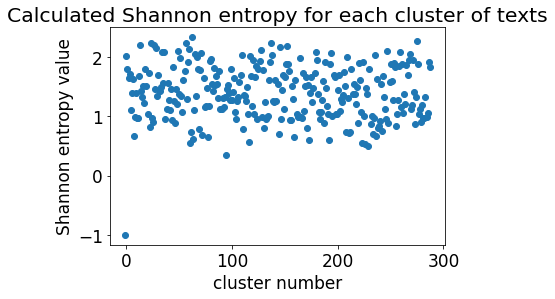

In [124]:
approximation_order = 2 # ngrams
sentences_list = []
entropy_rate_list = []
label_list = []
df_analysis = pd.DataFrame()
default_entropy = -1.
data['entropy'] = default_entropy

for label in clusters_ids:
    cluster = list(data[(data.cluster == label)].index.values)
    list_of_sentences = ['"'+data['docs'].values[i_]+'"' for i_ in cluster]
    if label > -1:
        model, stats = markov_model(chars(list_of_sentences),approximation_order)
        rate_ = entropy_rate(model, stats)
    else:
        rate_ = default_entropy
    
    # update data with entropy:
    for ind_ in cluster:
        data.loc[data.index == ind_,'entropy'] = rate_
    
    label_list.append(label)
    entropy_rate_list.append(rate_)
    sentences_list.append(list_of_sentences)
    
df_analysis['label'] = label_list
df_analysis['sentences'] = sentences_list
df_analysis['entropy'] = entropy_rate_list

plt.scatter(label_list, entropy_rate_list)
plt.title('Calculated Shannon entropy for each cluster of texts')
plt.xlabel('cluster number')
plt.ylabel('Shannon entropy value')
plt.show()

now, sanity check - Do all clusters make sense ?  
Available metrics to check the quality of clusters are based on numerical representation. 
The proposed method, uses the text-sentences belonging to a given cluster.   
In this part I omit 1-sentence clusters.   
   
The only parameters that needs to be introduced in the proposed method are:
- the 'approximation_order' which defines a number of of consecutive characters (known as ngrams) from which we create the probability distribution used later to calculate the Shanon entropy.
- the sensitivity parameter S (to adjust the aggressiveness in kneed detection [https://kneed.readthedocs.io/en/stable/parameters.html]) used in the kneed library.

Elbow point values:
 tekst_id= 273 ; threshold value= 2.0843631493063794


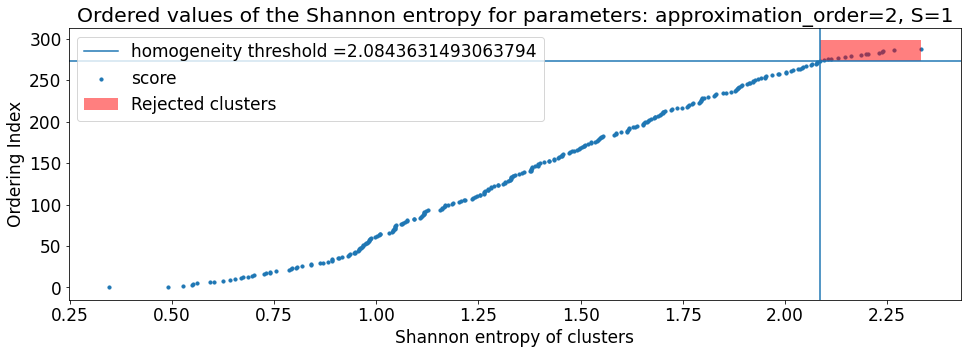

In [125]:
tmp_ = df_analysis.sort_values(by=['entropy']).copy()

y1 = tmp_[tmp_.entropy > -1.].entropy.values 
# determne elbow value:
x0 = list(range(len(y1)))
kn = KneeLocator(x0, y1, S=1., curve="convex", direction="increasing") 
elbow_1 = kn.knee
print ('Elbow point values:\n tekst_id=', elbow_1, '; threshold value=',y1[elbow_1])

plt.figure(figsize=(16,5))
plt.scatter(y1,x0,s=10,label='score')
plt.axvline(y1[elbow_1],label='homogeneity threshold ='+str(y1[elbow_1]))
plt.axhline(elbow_1)
plt.fill_between(y1, elbow_1, len(y1)+10, where=(x0>=elbow_1), 
                facecolor='red', alpha=0.5, label='Rejected clusters')
plt.xlabel('Shannon entropy of clusters')
plt.ylabel('Ordering Index')
plt.title('Ordered values of the Shannon entropy for parameters: approximation_order='+str(approximation_order) + ', S=1')
plt.legend()
plt.show()

threshold_entropy =y1[elbow_1]

In [126]:
y1[elbow_1],elbow_1

(2.0843631493063794, 273)

In [127]:
df_analysis[df_analysis.entropy > y1[elbow_1]]

label  \
2       59   
19     137   
33      13   
46     145   
60      23   
72     152   
109     62   
157     26   
161     56   
179     49   
194     28   
198    127   
250    275   
261    247   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Clusters with too high heterogeneity

In [128]:
for id, cluster in enumerate(clusters):
    if id in data[data.entropy > threshold_entropy].cluster.unique():
        print("Cluster {}, #{} Elements ".format(id, len(cluster))) 

Cluster 13, #10 Elements 
Cluster 23, #8 Elements 
Cluster 26, #8 Elements 
Cluster 28, #8 Elements 
Cluster 49, #6 Elements 
Cluster 56, #6 Elements 
Cluster 59, #5 Elements 
Cluster 62, #5 Elements 
Cluster 127, #4 Elements 
Cluster 137, #3 Elements 
Cluster 145, #3 Elements 
Cluster 152, #3 Elements 
Cluster 247, #3 Elements 
Cluster 275, #3 Elements 


In [129]:
for cl_ in data[data.entropy > threshold_entropy].cluster.unique():
    print (cl_,'=>',data[(data.cluster == cl_)][['label','entropy']].values)

59 => [['veg-oil' 2.130364717774363]
 ['veg-oil' 2.130364717774363]
 ['veg-oil' 2.130364717774363]
 ['soy-oil' 2.130364717774363]
 ['veg-oil' 2.130364717774363]]
137 => [['interest' 2.2368047682179175]
 ['money-supply' 2.2368047682179175]
 ['interest' 2.2368047682179175]]
13 => [['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]
 ['cocoa' 2.1983573617610244]]
145 => [['acq' 2.1622113991507894]
 ['acq' 2.1622113991507894]
 ['acq' 2.1622113991507894]]
23 => [['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]
 ['coffee' 2.2306816020217592]]
152 => [['trade' 2.185074651771886]
 ['trade' 2.185074651771886]
 ['trade

View of texts of the cluster 247

In [131]:
data[data.cluster==275]

docs  \
4992                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              BUNDESBANK SEEN STEERING STEADY MONETARY COURSE The Bundesbank is likely to steer a steady monetary course over the next few weeks and a change in credit policies is not expected at tomorrow s regular central bank council meeting, bank economists and dealers said. There is no need for action, Hermann Remsperger, chief economist of Berliner Handels and Frankfurter Bank BHF said. Others noted that exchange rates are stable after last month s Group of Six agreement in Paris and central bank money stock growth is still well above the three to six pct target zone, so a change in credit policies could be ruled out. One money market dealer said comments by Bundesbank President Karl Otto Poehl at a private seminar in Duesseldorf two weeks ago hinting at another interest rate cut only indicated the Bundesbank might act if conditions changed. Bank economists said U.S. Pressure on West Germany to further ease credit policies had receded since the Paris pact. But such demands could re emerge if West Germany failed to stimulate its economy enough to affect the massive U.S. Trade deficit. Remsperger said continued strong money supply growth also precluded a further cut in official interest rates. Central bank money stock was growing at an annualized 7.5 pct in February, unchanged from the 7.5 pct in January. Economists said some of the 18 members of the central bank council were worried about the continued overshoot in the money supply target and were bound to resist any moves to cut rates. But Poehl played down the risk of inflation. Economists said the fact that money stock growth remained stable last month was a success. Some said it was likely to return to within the target range later this year. The special factors which boosted money supply growth last year are disappearing, one economist said. He said some 75 pct of the money supply increase in 1986 was caused by a sharp rise in the inflow of foreign funds. This trend had been reversed recently and with domestic credit demand likely to remain at steady levels, money stock growth was expected to narrow in the medium term. These developments were increasing the Bundesbank s scope for a rate cut in the medium term, economists said. Money market dealers said period rates remained little changed, indicating no change in credit policy was expected. Call money rates declined to 3.75 80 pct from 3.90 95 yesterday, with the market well stocked with liquidity. Dealers said call money was soft because tax payments on behalf of customers had been less than expected so far. But rates were l

Accepted Clusters:

In [112]:
data[data.entropy <= threshold_entropy].cluster.unique()

array([ -1, 215,   0,   1, 133,   2, 232, 134, 266,  11,  55,  92, 135,
        38,   6, 136,  93,  29, 107,  45, 138, 139,  39,   5, 101, 140,
       141,  18,  94,  88,  19,   3, 250,  90, 142,  31,  32,  40,  60,
       143, 144,   9,  95,  21, 146, 167, 207,  96, 147,  30, 148,  65,
        84,  41, 179, 149, 108, 278,  10,  24,  48,  47, 150,  54, 151,
        58,  74, 102, 183,  97, 171, 213, 254, 245, 225,  36, 153, 257,
       190,  35, 260, 154, 155,  33,  98,  80, 156,  12, 157,  64,  22,
        61, 158,  53,   4, 159, 160, 161, 162, 163, 261, 164, 165,  63,
       166,  52, 168, 169,  85,  67,  99, 170, 128,  42,  68,  43,  57,
        78,  86, 100, 106, 172,  69,  44, 132, 105, 237, 173, 174, 175,
       258,  46, 263, 176, 115, 103, 178, 104,  34, 192, 273, 177,   8,
       119, 226, 114, 124, 180, 116, 256, 181, 187,  66,  27, 186, 265,
       191, 182, 184, 185, 109,  14, 188, 200,  20, 123, 189,  25, 194,
       110,  91, 193, 129, 201, 195,  79, 223, 196, 197, 198, 11